<a href="https://colab.research.google.com/github/P3lu-mi/Research-seminar2/blob/main/PLAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=0a7ea984adc1bb3e5b715e809686f93b0bdf7d37ac11193bf419fa61ad25f098
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [4]:
!pip install shap

#Import modules

In [5]:
import nltk
import string
import pickle
import shap
import lime.lime_text
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


#Load datasets

In [6]:
data = pd.read_csv("dataset.csv")

In [7]:
data.head()

,Unnamed: 0,source_text,plagiarized_text,label
0,0,Researchers have discovered a new species of b...,Scientists have found a previously unknown but...,1
1,1,The moon orbits the Earth in approximately 27....,Our natural satellite takes around 27.3 days t...,1
2,2,Water is composed of two hydrogen atoms and on...,H2O consists of 2 hydrogen atoms and 1 oxygen ...,1
3,3,The history of Rome dates back to 753 BC.,Rome has a long history that can be traced bac...,1
4,4,Pluto was once considered the ninth planet in ...,"In the past, Pluto was classified as the ninth...",1


In [10]:
def preprocess_text(text):
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = text.lower()
    stop_words = set(stopwords.words("english"))
    text = " ".join(word for word in text.split() if word not in stop_words)
    return text

data["source_text"] = data["source_text"].apply(preprocess_text)
data["plagiarized_text"] = data["plagiarized_text"].apply(preprocess_text)


In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

#Vectorization

In [11]:
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(data["source_text"] + " " + data["plagiarized_text"])


In [12]:
y = data["label"]


#Train-test splits]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#Train svm Model

In [14]:
model = SVC(kernel='linear', probability=True, random_state=42)

In [15]:
model.fit(X_train, y_train)

SVC(kernel='linear', probability=True, random_state=42)

# Evaluate Model

In [16]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.8783783783783784
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.89      0.87        35
           1       0.89      0.87      0.88        39

    accuracy                           0.88        74
   macro avg       0.88      0.88      0.88        74
weighted avg       0.88      0.88      0.88        74

Confusion Matrix:
 [[31  4]
 [ 5 34]]


# Save Model & Vectorizer

In [17]:
pickle.dump(model, open("model.pkl", 'wb'))
pickle.dump(tfidf_vectorizer, open("tfidf_vectorizer.pkl", 'wb'))


# Load Model & Vectorizer

In [18]:
model = pickle.load(open('model.pkl', 'rb'))
tfidf_vectorizer = pickle.load(open('tfidf_vectorizer.pkl', 'rb'))

# SHAP Explanations

In [42]:
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

model = SVC(kernel='linear', probability=True, random_state=42)
model.fit(X_train_dense, y_train)  # Train on dense data

import shap

explainer = shap.LinearExplainer(model, X_train_dense)
shap_values = explainer.shap_values(X_test_dense)

# Visualize SHAP explanation for first example

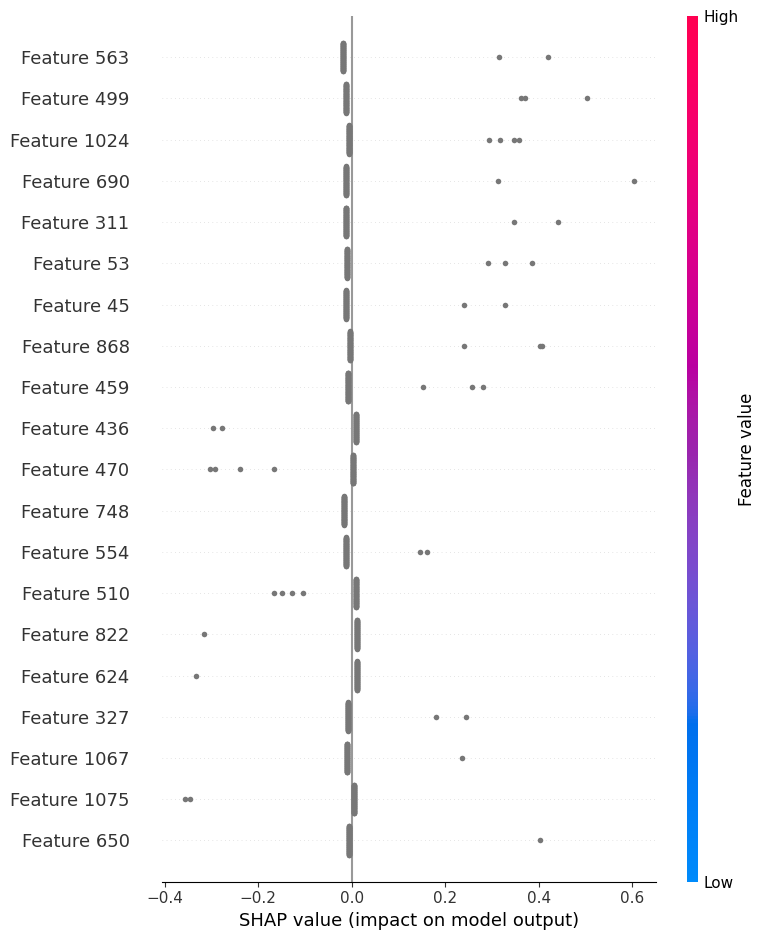

In [43]:
shap.summary_plot(shap_values, X_test)

# LIME Explanations

In [46]:
lime_explainer = lime.lime_text.LimeTextExplainer(class_names=['No Plagiarism', 'Plagiarism Detected'])

def explain_instance(input_text):
    vectorized_text = tfidf_vectorizer.transform([input_text])
    explanation = lime_explainer.explain_instance(input_text, model.predict_proba, num_features=10)
    explanation.show_in_notebook()
    return explanation

# Example Explanation

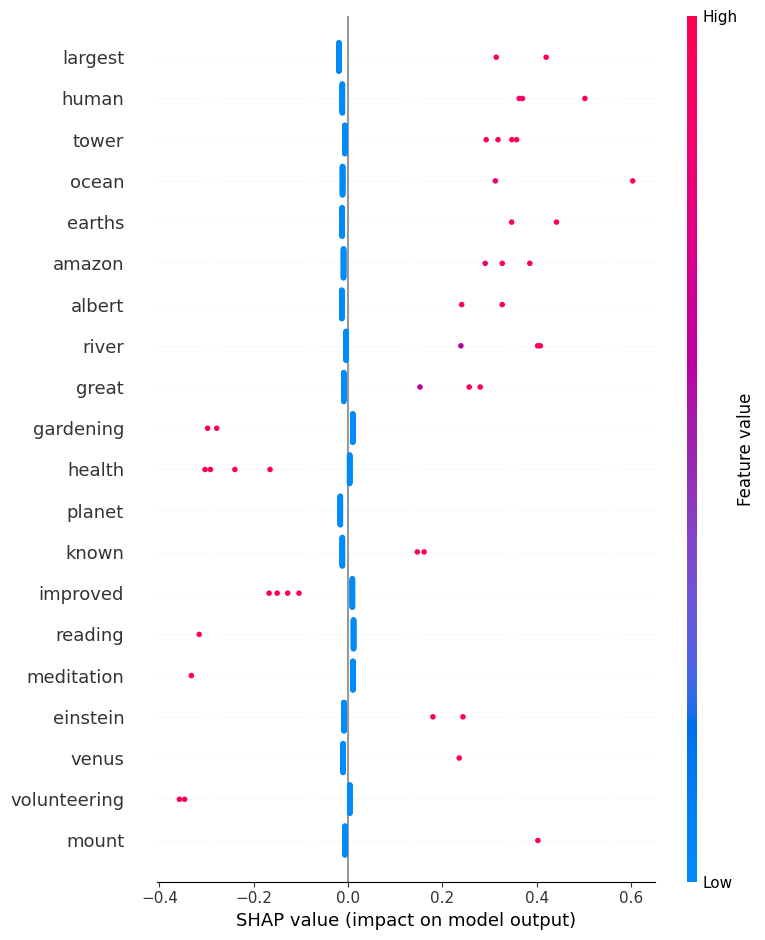

In [50]:
# Get feature names from the vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

# Convert the sparse matrix to a dense array
X_test_dense = X_test.toarray()

# Create a pandas DataFrame with feature names as columns
X_test_df = pd.DataFrame(X_test_dense, columns=feature_names)

# Now use the DataFrame in summary_plot
shap.summary_plot(shap_values, X_test_df)

In [25]:
!pip install shap